# 集合写真に写る人物の顔の大きさをもとに、
# 写真内で人物が前方・後方のどちらに位置しているかを分析する。
# 顔検出には YORO を用いた。

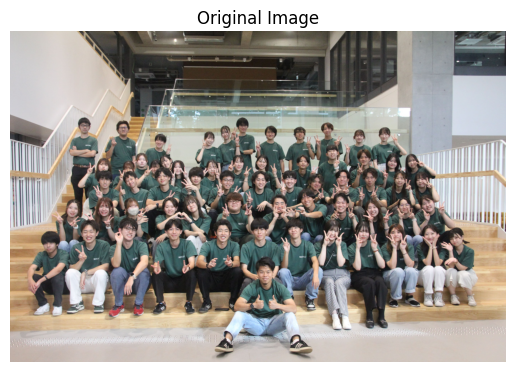

In [12]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("reitaku.jpg")
if img is None:
    raise FileNotFoundError("reitaku.jpg not found")

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original Image")
plt.show()


検出された顔の数: 62


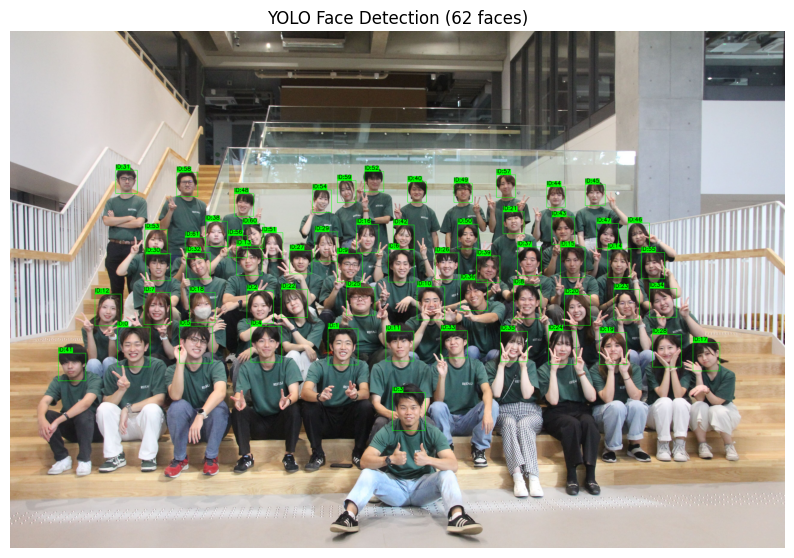

平均顔サイズ: 14950
最大顔サイズ: 27170
最小顔サイズ: 8004


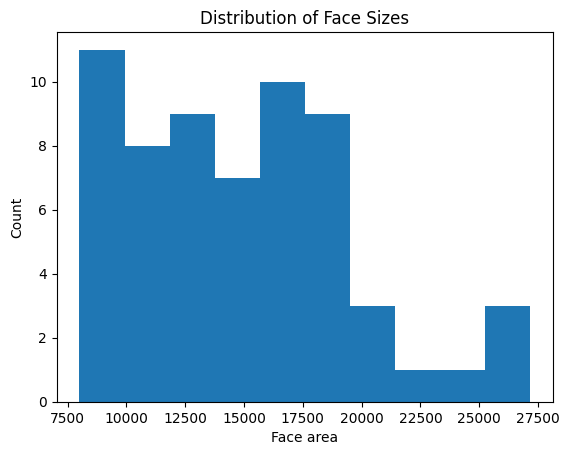

保存完了: reitaku_yolo_faces.jpg


In [13]:
import cv2
import numpy as np
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt

# =====================
# 1. 画像とモデル準備
# =====================
image_path = Path("reitaku.jpg")
model_path = Path("yolov8m-face.pt")  # ← あなたの環境で「動く」モデル

img = cv2.imread(str(image_path))
if img is None:
    raise FileNotFoundError("reitaku.jpg not found")

# =====================
# 2. YOLO 顔検出
# =====================
model = YOLO(model_path)
result = model.predict(
    source=str(image_path),
    conf=0.25,
    imgsz=1280,
    verbose=False
)[0]

boxes = result.boxes.xyxy.cpu().numpy()
print(f"検出された顔の数: {len(boxes)}")

# =====================
# 3. 描画設定
# =====================
annotated = img.copy()
h_img, w_img = annotated.shape[:2]
color = (0, 255, 0)
font_scale = 1.2
thickness = 2

areas = []  # ← 分析用（顔サイズ）

# =====================
# 4. 枠描画＋サイズ計算
# =====================
for idx, box in enumerate(boxes):
    x1, y1, x2, y2 = map(int, box)
    w = x2 - x1
    h = y2 - y1
    area = w * h
    areas.append(area)

    pad = int(max(w, h) * 0.2)
    x1p = max(0, x1 - pad)
    y1p = max(0, y1 - pad)
    x2p = min(w_img, x2 + pad)
    y2p = min(h_img, y2 + pad)

    cv2.rectangle(annotated, (x1p, y1p), (x2p, y2p), color, thickness)

    label = f"ID:{idx}"
    (tw, th), base = cv2.getTextSize(
        label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
    )
    cv2.rectangle(
        annotated,
        (x1p, y1p - th - base),
        (x1p + tw, y1p),
        color,
        -1
    )
    cv2.putText(
        annotated,
        label,
        (x1p, y1p - base),
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        (0, 0, 0),
        thickness,
        cv2.LINE_AA
    )

areas = np.array(areas)

# =====================
# 5. 結果画像表示
# =====================
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"YOLO Face Detection ({len(areas)} faces)")
plt.show()

# =====================
# 6. 分析結果表示
# =====================
print("平均顔サイズ:", int(areas.mean()))
print("最大顔サイズ:", int(areas.max()))
print("最小顔サイズ:", int(areas.min()))

plt.hist(areas, bins=10)
plt.xlabel("Face area")
plt.ylabel("Count")
plt.title("Distribution of Face Sizes")
plt.show()

# =====================
# 7. 高解像度保存
# =====================
output_path = Path("reitaku_yolo_faces.jpg")
annot_up = cv2.resize(
    annotated,
    (w_img * 2, h_img * 2),
    interpolation=cv2.INTER_CUBIC
)
cv2.imwrite(str(output_path), annot_up)
print("保存完了:", output_path)


# ■ こういう画像では精度が落ちた

顔が小さく写っている場合や、横顔・一部が隠れている場合には検出漏れが発生することがあった。また、暗い場所や逆光の画像では、顔と背景の区別が難しくなり、精度が低下すると感じた。

# ■ 今回のテーマでなぜこの技術が必要だったか

今回のテーマでは、画像に写っている人の数や配置を客観的に分析する必要があった。そのため、人の顔を自動で検出できるYOLOは、人手によるカウントを省き、再現性のある分析を行うために有効な技術であった。特に、顔検出を用いることで、単なる人数把握だけでなく、写真構図や人の密集度の分析にもつなげることができた。